In [56]:
import pandas as pd
import tensorflow as tf
import numpy as np
keras = tf.keras
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import random
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
import warnings
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [53]:
np.random.seed(4)

In [79]:
!ls data/clean/

Alito.csv     Ginsburg.csv  Kagan.csv     Roberts.csv   Thomas.csv
Breyer.csv    Gorsuch.csv   Kavanaugh.csv Sotomayor.csv


In [54]:
def balance_train_data(X, y, method=None):
    uniq, cts = np.unique(y, return_counts=True)
    
    if method == None:
        return X, y
    
    elif method == 'undersampling':
        #train_amt = cts[0] if cts[0] < cts[1] else cts[1]
        
        #replace_0 = False
        #replace_1 = False

        rus = RandomUnderSampler()
        
        X_train, y_train = rus.fit_resample(X, y)
        return X_train, y_train
    elif method == 'oversampling':    
        #train_amt = cts[0] if cts[0] > cts[1] else cts[1]
        
        #replace_0 = False if cts[0] > cts[1] else True
        #replace_1 = True if cts[0] > cts[1] else False
        
        ros = RandomOverSampler()
        X_train, y_train = ros.fit_resample(X, y)
        return X_train, y_train
    elif method == 'smote':
        smote = SMOTE()
        X_train, y_train = smote.fit_resample(X, y)
        return X_train, y_train
    elif method == 'both':
        smote = SMOTE(sampling_strategy=0.75)
        under = RandomUnderSampler(sampling_strategy=1)
        
        X_train, y_train = smote.fit_resample(X, y)
        X_train, y_train = under.fit_resample(X_train, y_train)
        
        return X_train, y_train
        
        
    else:
        print('Incorrect balance method')
        return
    
    #c_0_index = np.argwhere(y == 0).flatten()
    #c_1_index = np.argwhere(y == 1).flatten()
    
    #train_0 = np.random.choice(c_0_index, train_amt, replace=replace_0)
    #train_1 = np.random.choice(c_1_index, train_amt, replace=replace_1)
    
    #train = list(train_0)
    #train.extend(list(train_1))

    #np.random.shuffle(train)

    #return X[train], y[train]

In [35]:
def plot_cross_val(models, data, ax, sampling_method):

    X = data['cleanText'].to_numpy()
    y = data['vote'].to_numpy()

    kf = KFold(n_splits=10, shuffle=True)

    precisions = [[], [], []] 
    recalls = [[], [], []]
    
    for train, test in kf.split(X):
        X_test, y_test = X[test], y[test]
        X_train, y_train = X[train], y[train]
        
        tfidf = TfidfVectorizer()
        train_vectors = tfidf.fit_transform(X_train)
        test_vectors = tfidf.transform(X_test)  
        
        #X_train = X_train.reshape(len(X_train), 1)
        train_vectors, y_train = balance_train_data(train_vectors, y_train, method=sampling_method)
        
        #tfidf = TfidfVectorizer()
        #train_vectors = tfidf.fit_transform(X_train.flatten())
        #test_vectors = tfidf.transform(X_test)  
        for i, model in enumerate(models):
            model.fit(train_vectors, y_train)
            y_pred = model.predict(test_vectors)
            
            precisions[i].append(precision_score(y_test, y_pred))
            recalls[i].append(recall_score(y_test, y_pred))
    
    x = range(0, 10)
    colormap = {0 : 'r',
                1 : 'b',
                2 : 'g'}
    
    for i in range(len(models)):
        ax.plot(x, precisions[i], c=colormap[i], 
                linewidth=1, linestyle='-',
                label='%s Precision' % models[i].__class__.__name__)
        ax.plot(x, recalls[i], c=colormap[i], 
                linewidth=1, linestyle='--',
                label='%s Recall' % models[i].__class__.__name__)

            


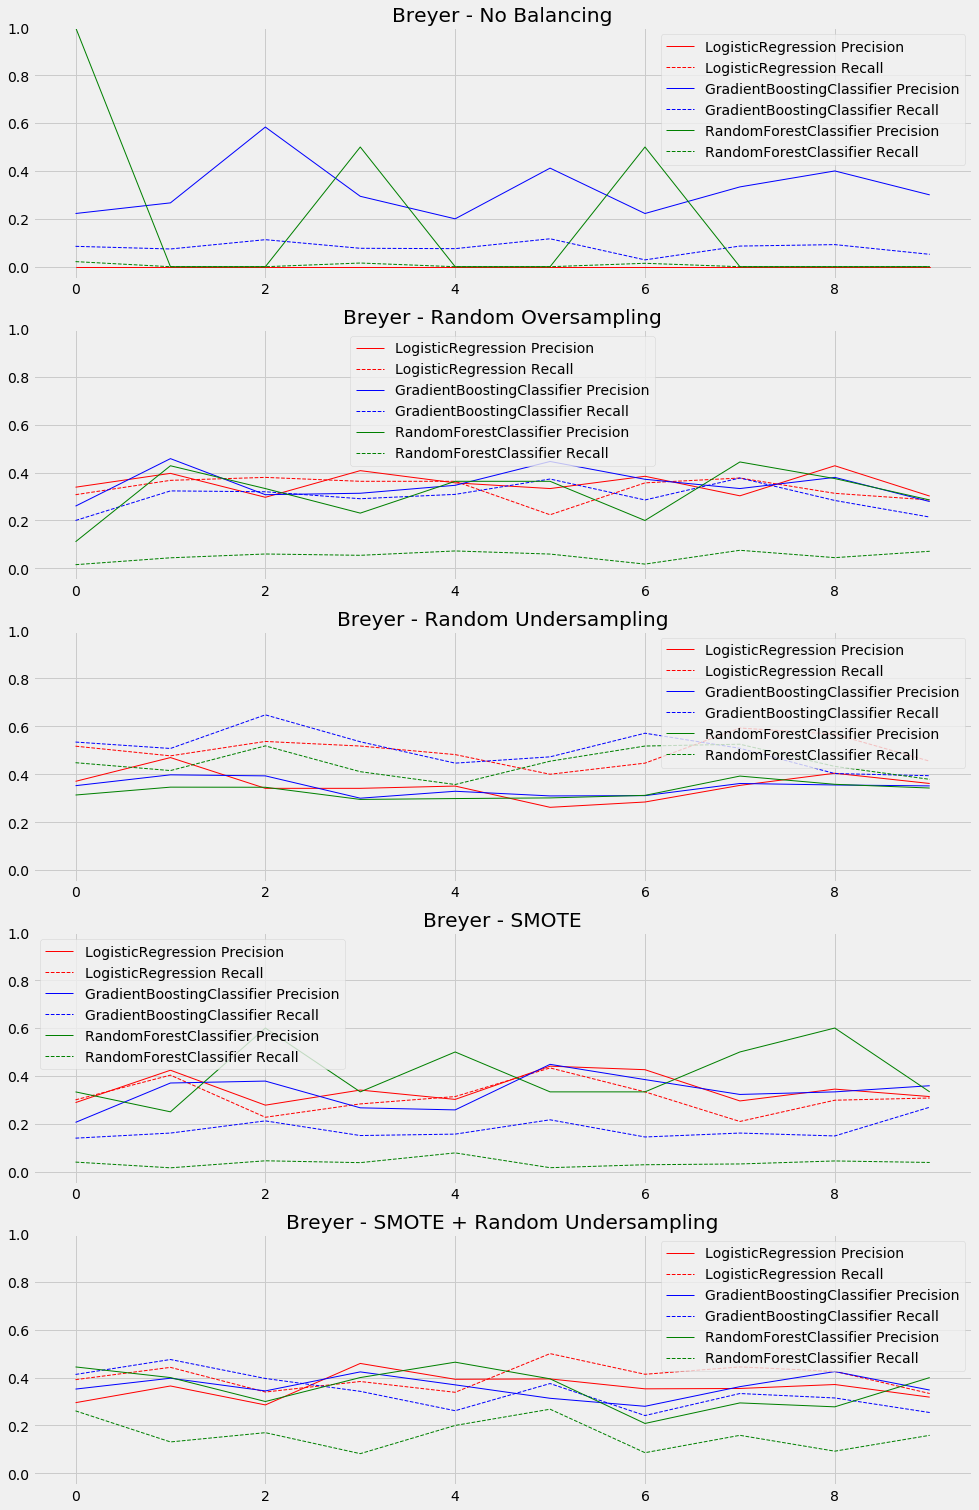

In [55]:
fig, ax = plt.subplots(5, 1, figsize=(15, 25))

methods = [None, 'oversampling', 'undersampling', 'smote', 'both']
titles = ['No Balancing', 'Random Oversampling', 'Random Undersampling', 'SMOTE', 'SMOTE + Random Undersampling']


for i, method in enumerate(methods):
    data = pd.read_csv('data/clean/Breyer.csv')
    data['cleanText'] = data['cleanText'].fillna(' ')
    models = [LogisticRegression(), GradientBoostingClassifier(), RandomForestClassifier()]
    plot_cross_val(models, data, ax[i], method)
    ax[i].set_title('Breyer - %s' % (titles[i]))
    ax[i].legend()
    ax[i].set_ylim(-0.05, 1)
    
    

In [39]:
X = data['cleanText'].to_numpy()
y = data['vote'].to_numpy()

In [42]:
print(len(y[y == 1]), len(y[y == 0]))

592 1119


In [49]:
tfidf = TfidfVectorizer()
train_vec = tfidf.fit_transform(X)

X_train, y_train = balance_train_data(train_vec, y, 'both')
print(len(y_train[y_train == 1]), len(y_train[y_train == 0]))

839 839


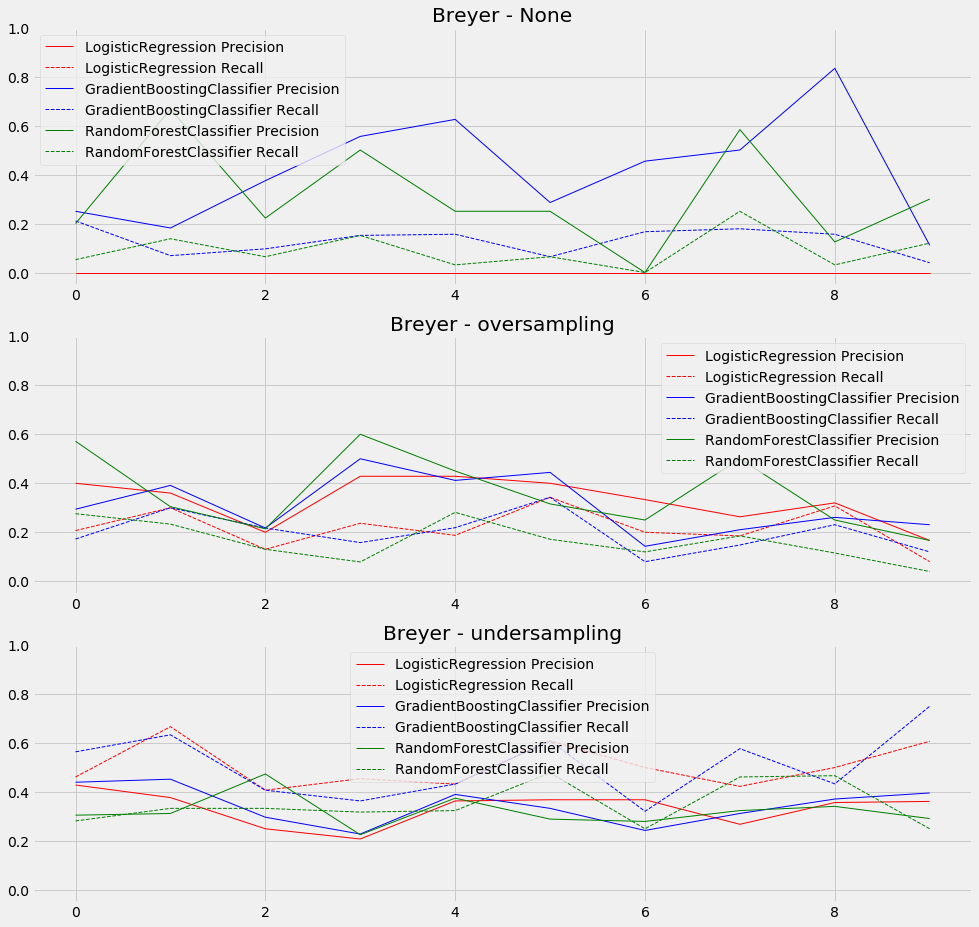

In [144]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

methods = [None, 'oversampling', 'undersampling']

for i, method in enumerate(methods):
    data = pd.read_csv('data/clean/Alito.csv')
    data['cleanText'] = data['cleanText'].fillna(' ')
    models = [LogisticRegression(), GradientBoostingClassifier(), RandomForestClassifier()]
    plot_cross_val(models, data, ax[i], method)
    ax[i].set_title('Alito - %s' % (str(method)))
    ax[i].legend()
    ax[i].set_ylim(-0.05, 1)
    
    

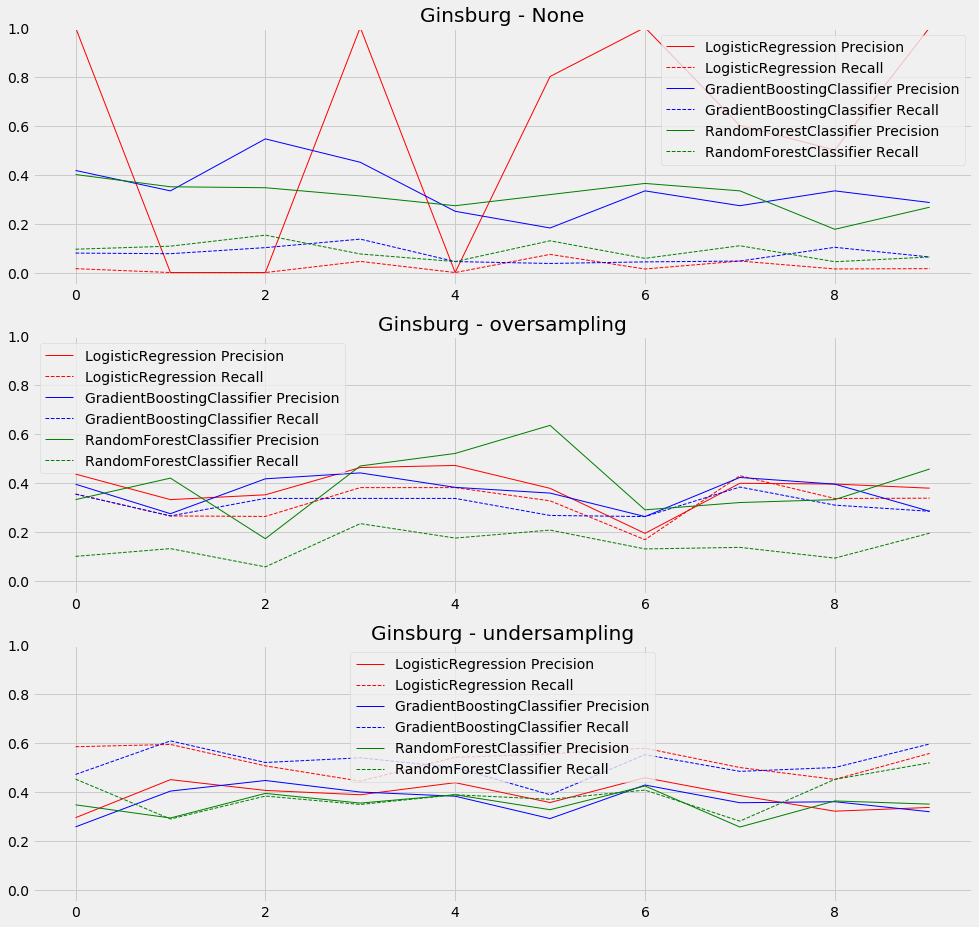

In [145]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

methods = [None, 'oversampling', 'undersampling']

for i, method in enumerate(methods):
    data = pd.read_csv('data/clean/Ginsburg.csv')
    data['cleanText'] = data['cleanText'].fillna(' ')
    models = [LogisticRegression(), GradientBoostingClassifier(), RandomForestClassifier()]
    plot_cross_val(models, data, ax[i], method)
    ax[i].set_title('Ginsburg - %s' % (str(method)))
    ax[i].legend()
    ax[i].set_ylim(-0.05, 1)
    
    

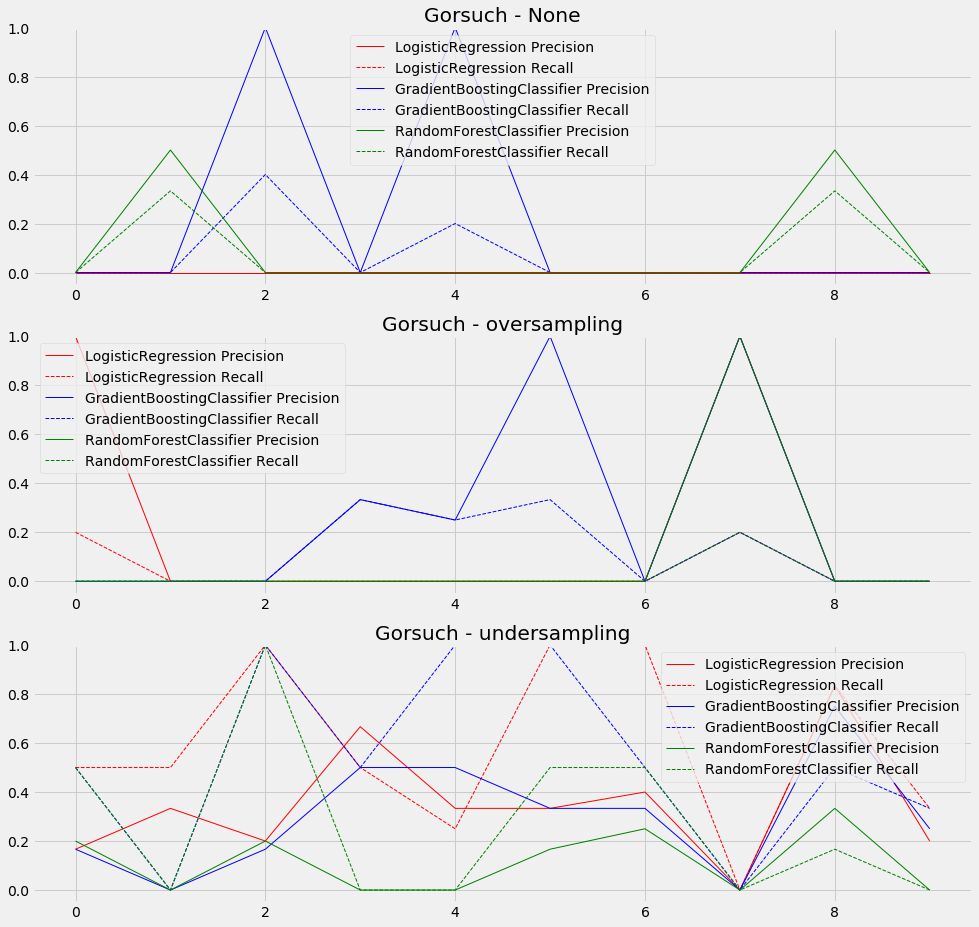

In [146]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

methods = [None, 'oversampling', 'undersampling']

for i, method in enumerate(methods):
    data = pd.read_csv('data/clean/Gorsuch.csv')
    data['cleanText'] = data['cleanText'].fillna(' ')
    models = [LogisticRegression(), GradientBoostingClassifier(), RandomForestClassifier()]
    plot_cross_val(models, data, ax[i], method)
    ax[i].set_title('Gorsuch - %s' % (str(method)))
    ax[i].legend()
    ax[i].set_ylim(-0.05, 1)
    
    

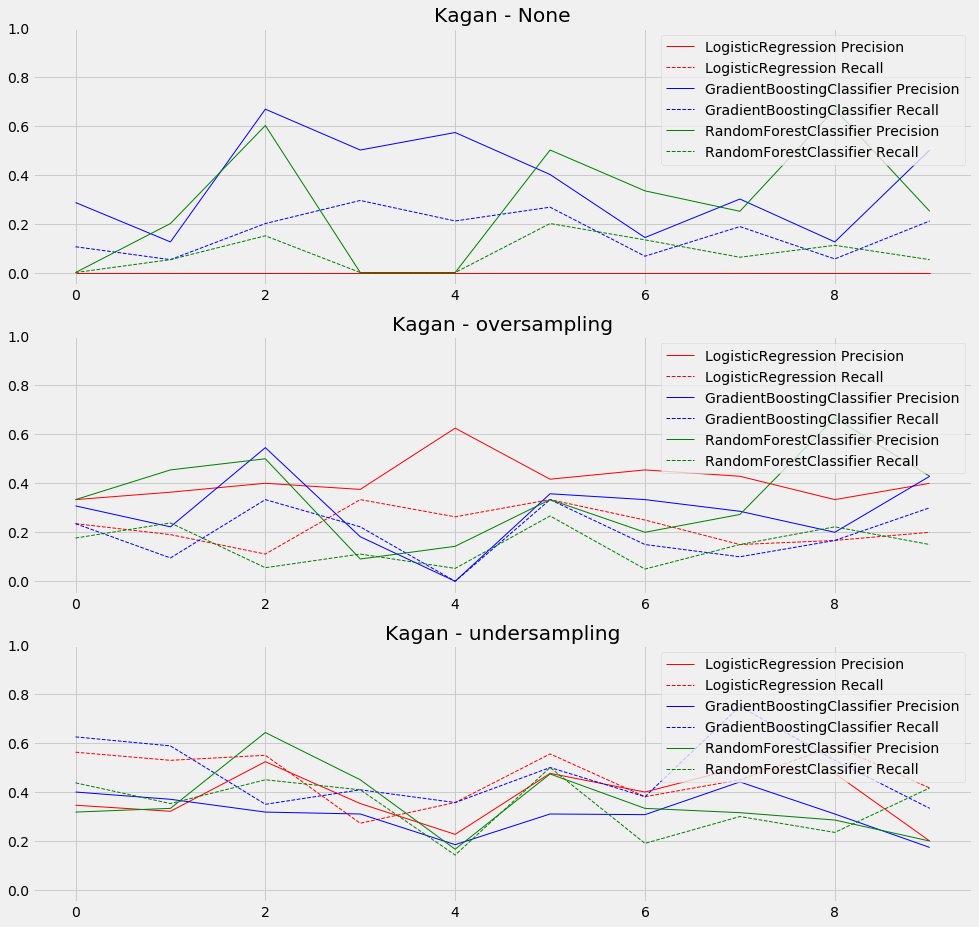

In [147]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

methods = [None, 'oversampling', 'undersampling']

for i, method in enumerate(methods):
    data = pd.read_csv('data/clean/Kagan.csv')
    data['cleanText'] = data['cleanText'].fillna(' ')
    models = [LogisticRegression(), GradientBoostingClassifier(), RandomForestClassifier()]
    plot_cross_val(models, data, ax[i], method)
    ax[i].set_title('Kagan - %s' % (str(method)))
    ax[i].legend()
    ax[i].set_ylim(-0.05, 1)
    
    

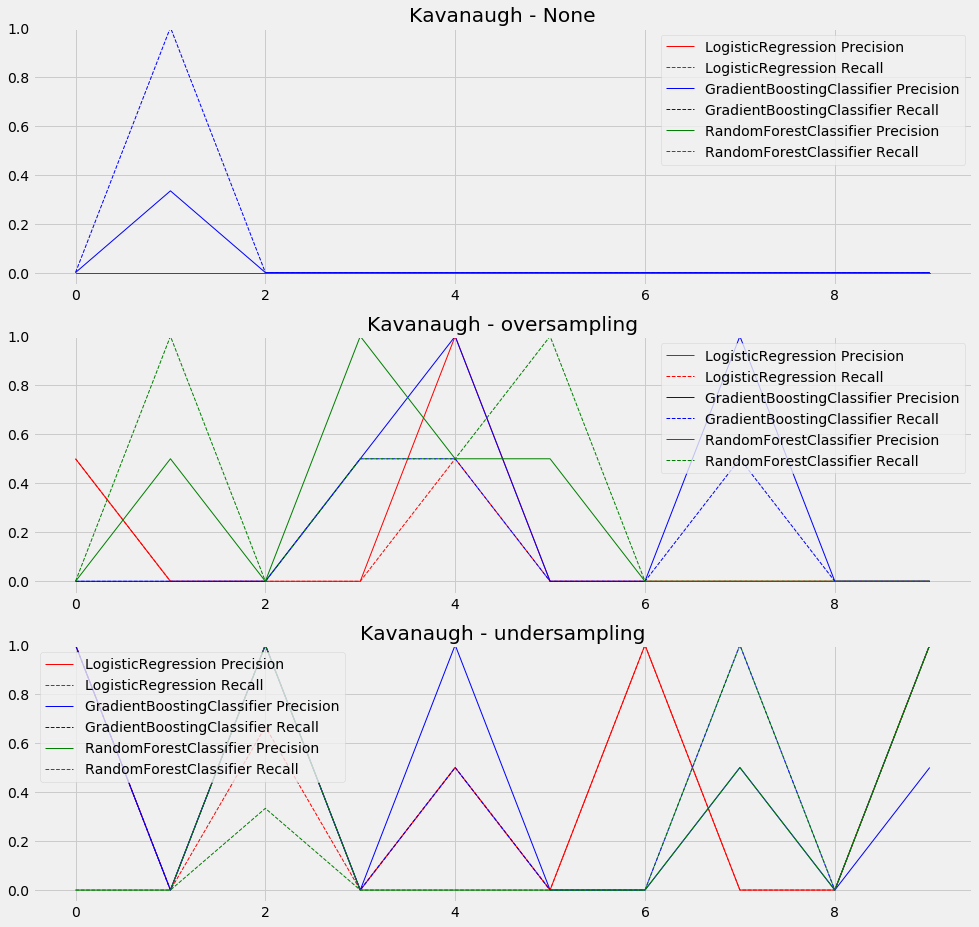

In [148]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

methods = [None, 'oversampling', 'undersampling']

for i, method in enumerate(methods):
    data = pd.read_csv('data/clean/Kavanaugh.csv')
    data['cleanText'] = data['cleanText'].fillna(' ')
    models = [LogisticRegression(), GradientBoostingClassifier(), RandomForestClassifier()]
    plot_cross_val(models, data, ax[i], method)
    ax[i].set_title('Kavanaugh - %s' % (str(method)))
    ax[i].legend()
    ax[i].set_ylim(-0.05, 1)
    
    

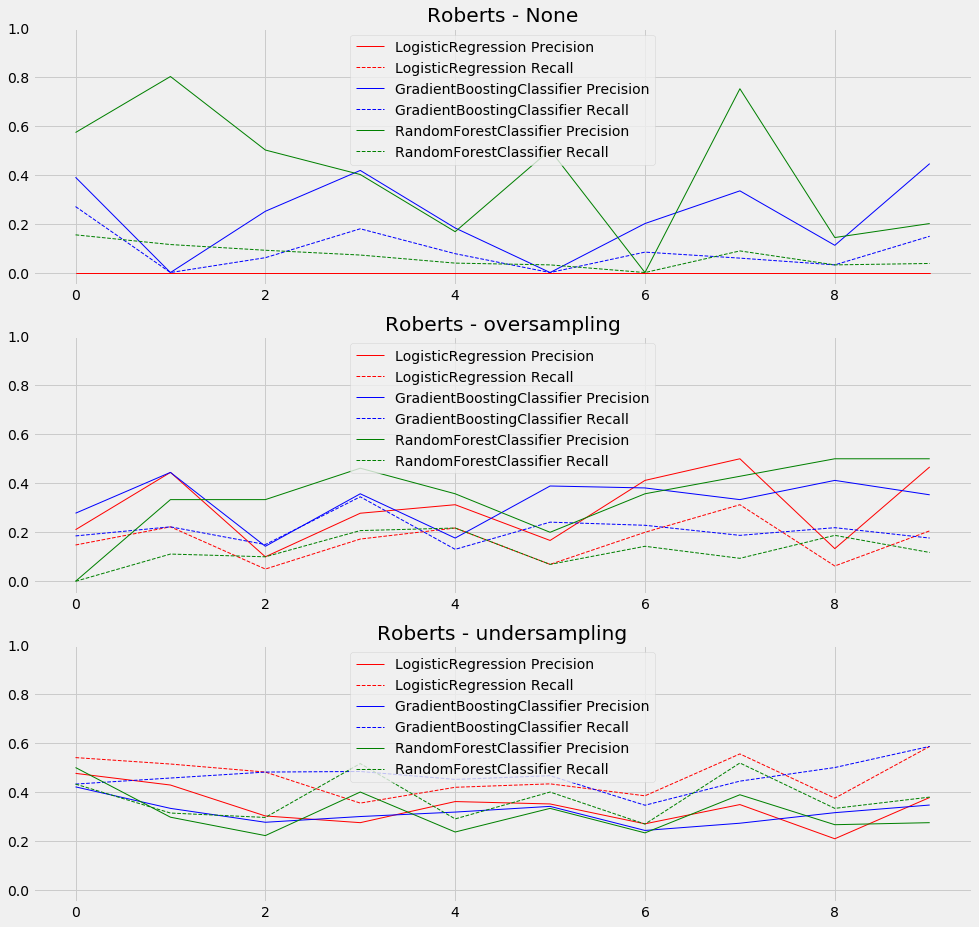

In [149]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

methods = [None, 'oversampling', 'undersampling']

for i, method in enumerate(methods):
    data = pd.read_csv('data/clean/Roberts.csv')
    data['cleanText'] = data['cleanText'].fillna(' ')
    models = [LogisticRegression(), GradientBoostingClassifier(), RandomForestClassifier()]
    plot_cross_val(models, data, ax[i], method)
    ax[i].set_title('Roberts - %s' % (str(method)))
    ax[i].legend()
    ax[i].set_ylim(-0.05, 1)
    
    

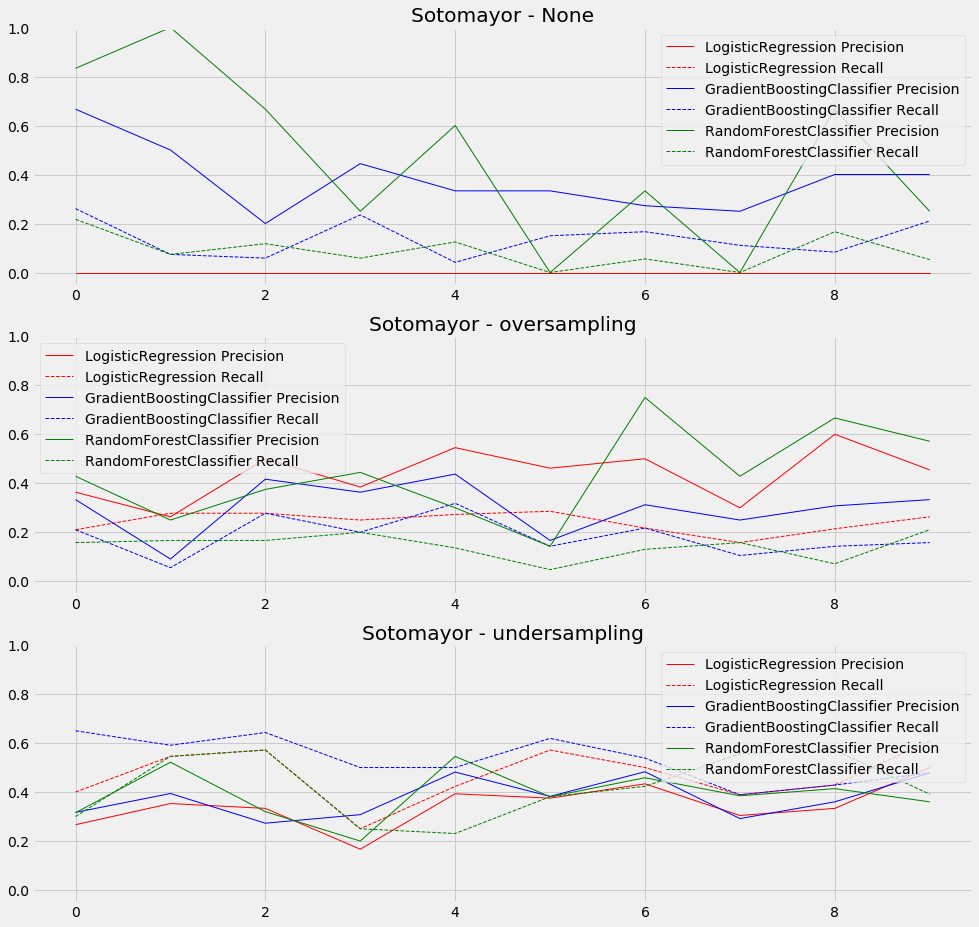

In [150]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

methods = [None, 'oversampling', 'undersampling']

for i, method in enumerate(methods):
    data = pd.read_csv('data/clean/Sotomayor.csv')
    data['cleanText'] = data['cleanText'].fillna(' ')
    models = [LogisticRegression(), GradientBoostingClassifier(), RandomForestClassifier()]
    plot_cross_val(models, data, ax[i], method)
    ax[i].set_title('Sotomayor - %s' % (str(method)))
    ax[i].legend()
    ax[i].set_ylim(-0.05, 1)
    
    

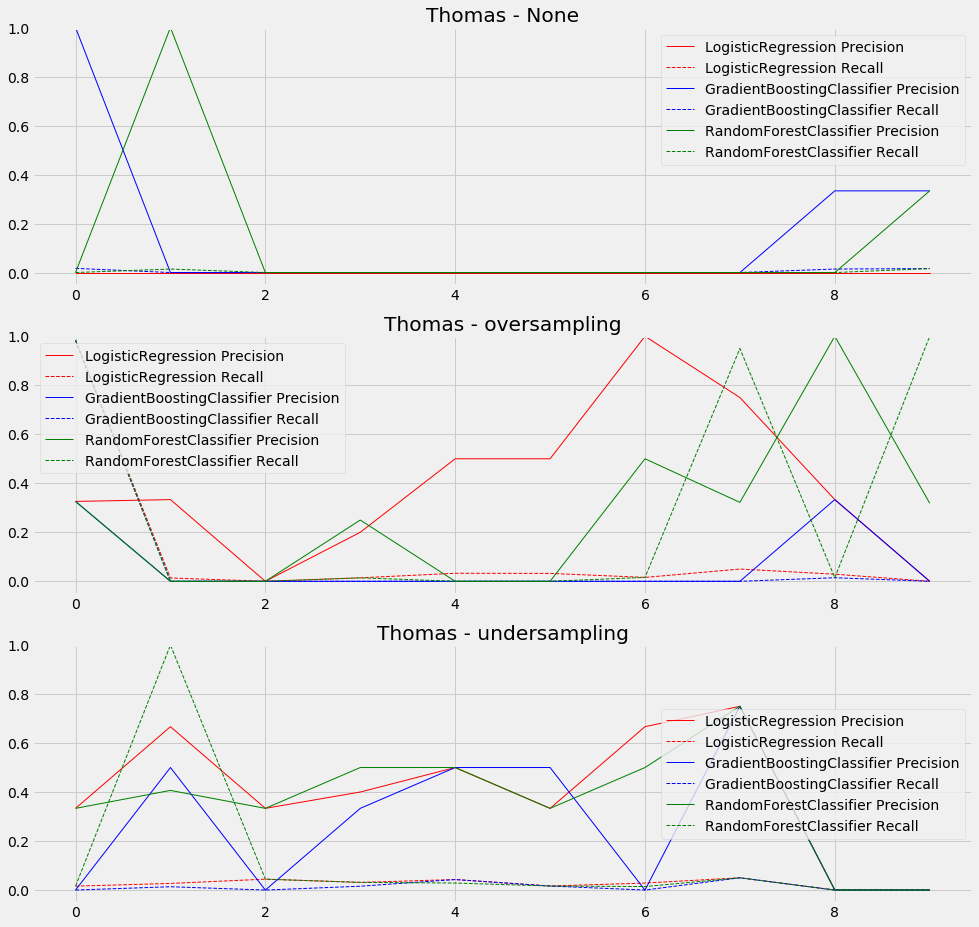

In [151]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

methods = [None, 'oversampling', 'undersampling']

for i, method in enumerate(methods):
    data = pd.read_csv('data/clean/Thomas.csv')
    data['cleanText'] = data['cleanText'].fillna(' ')
    models = [LogisticRegression(), GradientBoostingClassifier(), RandomForestClassifier()]
    plot_cross_val(models, data, ax[i], method)
    ax[i].set_title('Thomas - %s' % (str(method)))
    ax[i].legend()
    ax[i].set_ylim(-0.05, 1)
    
    